In [1]:
import socket

In [2]:
socket.gethostname() 

'char'

In [3]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, geo_tools, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import pytz
import matplotlib.ticker as ticker
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select, and_, or_, not_, func

from matplotlib.colors import LogNorm

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [4]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ONC/'
dbname='ONCSmallTDP3'

engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite')
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

# existing tables:
TDPTurbTBL=Base.classes.TDPTurbTBL
TDPSalTBL=Base.classes.TDPSalTBL
GriddedTDPTBL=Base.classes.GriddedTDPTBL

session = create_session(bind = engine, autocommit = False, autoflush = True)

### Check which time interval is included in the database:

In [5]:
session.query(GriddedTDPTBL).count()

784234

In [6]:
session.query(func.max(GriddedTDPTBL.Year)).one()

(2016)

In [7]:
session.query(func.min(GriddedTDPTBL.Year)).one()

(2014)

In [8]:
session.query(func.max(GriddedTDPTBL.Month)).filter(GriddedTDPTBL.Year==2016).one()

(11)

In [9]:
session.query(func.min(GriddedTDPTBL.Month)).filter(GriddedTDPTBL.Year==2014).one()

(8)

In [10]:
session.query(func.max(GriddedTDPTBL.Month)).one()

(12)

Answer: Aug 2014 - Nov 2016

### Select May 2015 data and map it
Note: GriddedTDPTBL contains data from the Tsawwassen-Duke Point route gridded to produce the average over each combination of (model grid i, model grid j, hour). It is still a lot of data.

In [11]:
df=pd.DataFrame(session.query(GriddedTDPTBL.Modeli,GriddedTDPTBL.Modelj,GriddedTDPTBL.N_Turb,GriddedTDPTBL.N_SA).\
                filter(and_(GriddedTDPTBL.Year==2015,GriddedTDPTBL.Month==5)).all())

In [12]:
print(f'There are {len(df)} rows if the data is restricted to May 2015')

There are 34978 rows if the data is restricted to May 2015


Text(0, 0.5, 'Gridded Value Count')

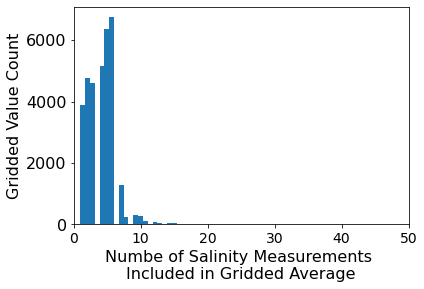

In [13]:
plt.hist(df['N_SA'],500);
plt.xlim(0,50)
plt.xlabel('Numbe of Salinity Measurements \nIncluded in Gridded Average')
plt.ylabel('Gridded Value Count')

In [14]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]
    lmask=-1*(tmask[0,0,:,:]-1)

Exclude red (more than 10 points per gridded value), magenta (less than 3 points per gridded value)  and black (close to port) points


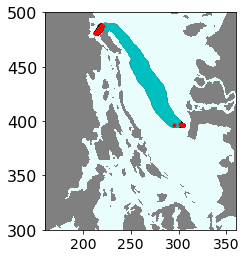

In [15]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
cmap=plt.get_cmap(cmocean.cm.ice_r)
cmap.set_bad('gray')
ax.pcolormesh(np.ma.masked_where(tmask[0,0,:,:]==0,tmask[0,0,:,:]),cmap=cmap)
ax.set_xlim((160,360))
ax.set_ylim((300,500))
viz_tools.set_aspect(ax,coords='coords')
ax.plot(df['Modeli'],df['Modelj'],'k.')
df2=df.loc[(df.Modeli>220)&(df.Modeli<300)]
ax.plot(df2['Modeli'],df2['Modelj'],'c.')
df3=df.loc[df.N_SA>10]
ax.plot(df3['Modeli'],df3['Modelj'],'r.')
print('Exclude red (more than 10 points per gridded value), magenta (less than 3 points per gridded value)',
      ' and black (close to port) points')

In [16]:
df=pd.DataFrame(session.query(GriddedTDPTBL.Year,GriddedTDPTBL.Month,GriddedTDPTBL.Day,GriddedTDPTBL.Hour,
                              GriddedTDPTBL.MLat,GriddedTDPTBL.MLon,
                              GriddedTDPTBL.Modeli.label('i'),GriddedTDPTBL.Modelj.label('j'),
                              GriddedTDPTBL.Avg_CT,GriddedTDPTBL.AvgSA,
                              GriddedTDPTBL.AvgChl_ugl,GriddedTDPTBL.AvgTurb_NTU).\
                filter(and_(GriddedTDPTBL.Year==2015,GriddedTDPTBL.Month==5,
                           GriddedTDPTBL.Modeli>220,GriddedTDPTBL.Modeli<300,
                           GriddedTDPTBL.N_SA<10,
                           GriddedTDPTBL.N_SA>=3)).all())

In [17]:
df.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'MLat', 'MLon', 'i', 'j', 'Avg_CT',
       'AvgSA', 'AvgChl_ugl', 'AvgTurb_NTU'],
      dtype='object')

In [18]:
df['dtUTC']=[dt.datetime(iyr,imn,idy,ihr) for ii,(iyr,imn,idy,ihr) in df[['Year','Month','Day','Hour']].iterrows()]

In [19]:
PATH= '/results/SalishSea/nowcast-green.201812/'
start_date = dt.datetime(2015,5,1)
end_date = dt.datetime(2015,6,1)
flen=1
namfmt='nowcast'
filemap={'vosaline':'grid_T','votemper':'grid_T'}
fdict={'turb_T':1,'grid_T':1}

In [20]:
it0=dt.datetime.now()
data=et.matchData(df,filemap, fdict, start_date, end_date, namfmt, PATH, flen,method='ferry',preIndexed=True)
print('Time elapsed: ',dt.datetime.now()-it0)

ferry
data is matched to mean of upper 3 model levels
done index grid_T 2021-02-04 14:48:26.071845
grid_T progress: 0.0%
grid_T progress: 10.000437655914919%
grid_T progress: 20.000875311829837%
grid_T progress: 30.00131296774476%
grid_T progress: 40.001750623659674%
grid_T progress: 50.0021882795746%
grid_T progress: 60.00262593548952%
grid_T progress: 70.00306359140444%
grid_T progress: 80.00350124731935%
grid_T progress: 90.00393890323429%
Time elapsed:  0:04:03.007287


In [21]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'MLat', 'MLon', 'i', 'j', 'Avg_CT',
       'AvgSA', 'AvgChl_ugl', 'AvgTurb_NTU', 'dtUTC', 'mod_vosaline',
       'mod_votemper', 'indf_grid_T', 'ih_grid_T'],
      dtype='object')

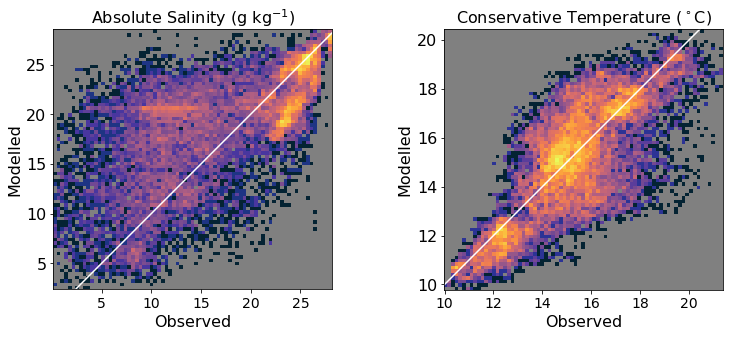

In [22]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(wspace=.4)
cmap=cmocean.cm.thermal
cmap.set_bad('gray')
h,x,y,m2=ax[0].hist2d(data['AvgSA'],data['mod_vosaline'],cmap=cmap,bins=25*3,norm=LogNorm());
ax[0].set_xlabel('Observed')
ax[0].set_ylabel('Modelled')
ax[0].plot((0,35),(0,35),'w-')
ax[0].set_title('Absolute Salinity (g kg$^{-1}$)')
ax[0].set_aspect(1)
h,x,y,m=ax[1].hist2d(data['Avg_CT'],data['mod_votemper'],cmap=cmap,bins=25*3,norm=LogNorm());#
ax[1].set_xlabel('Observed')
ax[1].set_ylabel('Modelled')
ax[1].plot((0,36),(0,36),'w-')
ax[1].set_title('Conservative Temperature ($^\circ$C)')
ax[1].set_aspect(1)
#fig.colorbar(m,ax=ax[1])
#fig.colorbar(m2,ax=ax[0])

In [23]:
session.close()
engine.dispose()